In [1]:
import numpy as np
import scipy
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os

In [2]:
nTurn = 1024
pipe_radius = 0.02*2.0**0.5

In [3]:
beam,lattice = impact.readInputFile('test.SF.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

lattice=[lattice[0],lattice[2]]

betx = lattice[1].betx
NL_t = lattice[1].strength_t
NL_c = lattice[1].transverse_scale_c
lattice[1].n_sckick = 50
lattice[1].n_map = 5

reading ImpactZ input file (test.SF.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


### Check pData

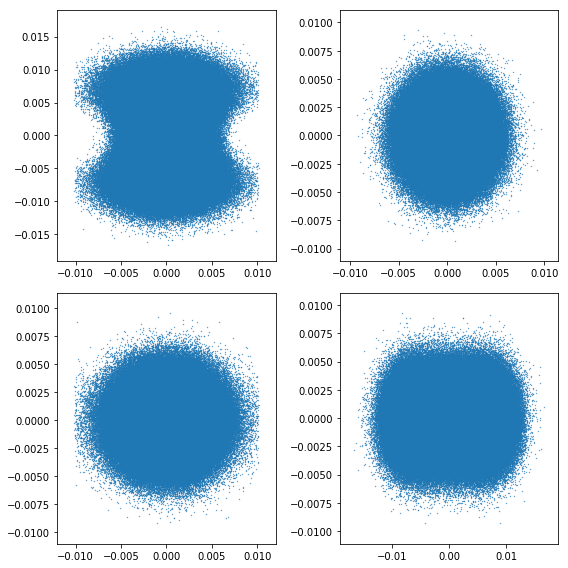

In [4]:
pData = impact.readParticleData('partcl.data.chad',ke,mass,freq)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.subplot(2,2,2)
plt.scatter(pData[:,1],pData[:,3],s=0.1)
plt.subplot(2,2,3)
plt.scatter(pData[:,0],pData[:,1],s=0.1)
plt.subplot(2,2,4)
plt.scatter(pData[:,2],pData[:,3],s=0.1)
plt.tight_layout()

### filter 1st octant

In [5]:
npt=0
for i in range(len(pData)):
    if pData[i,0]>0.0 and pData[i,2]>0.0:
        npt=npt+1

k=0
pData1octant = np.zeros([npt,9])
for i in range(len(pData)):
    if pData[i,0]>0.0 and pData[i,2]>0.0:
        pData1octant[k,:]=pData[i,:]
        k=k+1
        
pData = pData1octant
pData1octant = None

for i in range(npt):
    pData[i,-1] = i+1

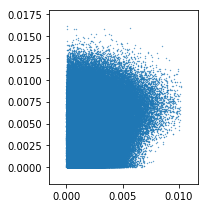

In [6]:
plt.figure(figsize=(3,3))
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.tight_layout()

In [7]:
latticeTmp = [impact.getElem('loop'),impact.getElem('write_raw_ptcl')]
latticeTmp[0].turns=1
latticeTmp[-1].file_id = -111110
latticeTmp[-1].turn = 1
beam.n_particles = npt
impact.writeParticleData(pData, ke, mass, freq)
beam.nCore_y = 1
beam.nCore_z = 1
impact.writeInputFile(beam,latticeTmp)
impact.run(beam)

0

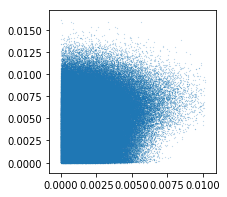

In [8]:
pData = impact.readParticleData(-111110,ke,mass,freq)
plt.figure(figsize=(3,3))
plt.scatter(pData[:,0],pData[:,2],s=0.01)

In [9]:
TBT = impact.getElem('TBT')
TBT.file_id = nTurn*2
lattice.insert(1,TBT)

TBT_integral = impact.getElem('TBT_integral')
TBT_integral.file_id = nTurn*2
TBT_integral.betx = betx
TBT_integral.alfx = 0.0
TBT_integral.strength_t = NL_t
TBT_integral.transverse_scale_c = NL_c
lattice.insert(2,TBT_integral)

lattice[0].turns = nTurn*2

for i in range(len(lattice)):
    if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
        lattice[i].pipe_radius = pipe_radius
        
lattice.append(impact.getElem('write_raw_ptcl'))
lattice[-1].turn = nTurn
lattice[-1].file_id = -nTurn

In [10]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 111110
beam.nCore_y = 6
beam.nCore_z = 4
impact.writeInputFile(beam,lattice,'test.in.'+str(nTurn)+'.forward') 
#impact.run(beam)

In [11]:
with open('test.in.'+str(nTurn)+'.forward') as f:
    testIn=f.read()
print(testIn)

!================= Beam & Control Parameters ================= 
6 4 
6 250089 1 0 1 
64 64 1025 9 0.0338514 0.0338514 0.1 
-23 0 0 1 
250089 
0.0 
1.0657889726792521e-09 
111110 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
2.209277215189872 1.065789e-10 0.0 1.0 1.0 0.0 0.0 
0.0 2500000.0 938272045.0 1.0 30000000.0 0.0 
!========================== Lattice ========================== 
0.0 0 0 -16 0.0 2048 / 
0.0 0 2048 -89 / 
0.0 0 2048 -88 1.2732395447351628 0.0 0.4 0.01 / 
1.8 50 5 9 0.4 0.01 1.2732395447351628 0.028284271247461905 / 
0.0 0 -1024 -2 1024 1 / 

